# `Fase #3 --> A/B Testing`

#### Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

> 📌 En esta fase se busca evaluar si existen diferencias significativas en el número de vuelos reservados según el nivel educativo de los clientes.

In [1]:

# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('DF_DATA#3.csv')
df.sample(5)

,Loyalty_Number,Year,Month,Flights_Booked,Flights_with_Companions,Total_Flights,Distance,Points_Accumulated,Points_Redeemed,Dollar_Cost_Points_Redeemed,Country,Province,City,Postal_Code,Gender,Education,Salary,Marital_Status,Loyalty_Card,CLV,Enrollment_Type,Enrollment_Year,Enrollment_Month
208247,446662,2018,January,0,0,0,0,0.0,0,0,Canada,British Columbia,Victoria,V10 6T5,Female,College,73479.0,Married,Nova,7046.48,Standard,2018,11
151320,106046,2017,November,10,3,13,2145,214.0,327,27,Canada,Quebec,Montreal,H2T 9K8,Male,Bachelor,16628.0,Single,Star,2658.22,2018 Promotion,2018,4
21486,352092,2017,February,1,1,2,2706,270.0,0,0,Canada,Quebec,Montreal,H4G 3T4,Male,Bachelor,94459.0,Married,Aurora,8096.31,Standard,2017,5
351803,923761,2018,September,3,3,6,606,60.0,0,0,Canada,Quebec,Montreal,H2T 9K8,Female,College,73479.0,Divorced,Star,2659.71,Standard,2014,9
296374,661274,2018,June,0,0,0,0,0.0,0,0,Canada,British Columbia,Vancouver,V5R 1W3,Female,Bachelor,90587.0,Married,Aurora,5408.91,Standard,2014,1


### 1. Preparación de Datos: Filtra el conjunto de datos para incluir únicamente las columnas relevantes: `'Flights Booked' y 'Education'`.

In [6]:
level_education_fly = df[['Education', 'Flights_Booked']]
level_education_fly

,Education,Flights_Booked
0,Bachelor,3
1,College,10
2,College,6
3,Bachelor,0
4,Bachelor,0
...,...,...
403755,College,0
403756,Doctor,0
403757,Bachelor,3
403758,College,0


In [7]:
level_education_fly['Education'].unique()

array(['Bachelor', 'College', 'Master', 'High School or Below', 'Doctor'],
      dtype=object)

In [8]:
# Agrupar los datos por nivel educativo y calcular estadísticas descriptivas
group_edu = level_education_fly.groupby('Education')['Flights_Booked'].count().reset_index
group_edu

<bound method Series.reset_index of Education
Bachelor                252567
College                 102260
Doctor                   17731
High School or Below     18915
Master                   12287
Name: Flights_Booked, dtype: int64>

In [7]:
# Agrupar los datos por nivel educativo y calcular estadísticas descriptivas
group_edu_mediana = level_education_fly.groupby('Education')['Flights_Booked'].median().reset_index
group_edu_mediana

<bound method Series.reset_index of Education
Bachelor                1.0
College                 1.0
Doctor                  1.0
High School or Below    1.0
Master                  1.0
Name: Flights_Booked, dtype: float64>

### 2. Análisis Descriptivo: Agrupa los datos por nivel educativo y calcula estadísticas descriptivas básicas (como el promedio, la desviación estandar, los percentiles) del número de vuelos reservados para cada grupo.

In [9]:
# Agrupar los datos por nivel educativo y calcular estadísticas descriptivas
descriptive_stats = level_education_fly.groupby('Education')['Flights_Booked'].describe()
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
Education,,,,,,,,
Bachelor,252567.0,4.110288,5.221671,0.0,0.0,1.0,8.0,21.0
College,102260.0,4.169744,5.246040,0.0,0.0,1.0,8.0,21.0
Doctor,17731.0,4.175512,5.256971,0.0,0.0,1.0,8.0,21.0
High School or Below,18915.0,4.176209,5.239267,0.0,0.0,1.0,8.0,21.0
Master,12287.0,4.200700,5.213956,0.0,0.0,1.0,8.0,21.0


> 📌 Revisando los datos que nos aporta la tabla, se puede ver que todos los niveles educativos tienen una media de 4.1/4.2 y en general se parecen los valores restantes.
Veamoslo ahora en una gráfica para tener un contexto visual

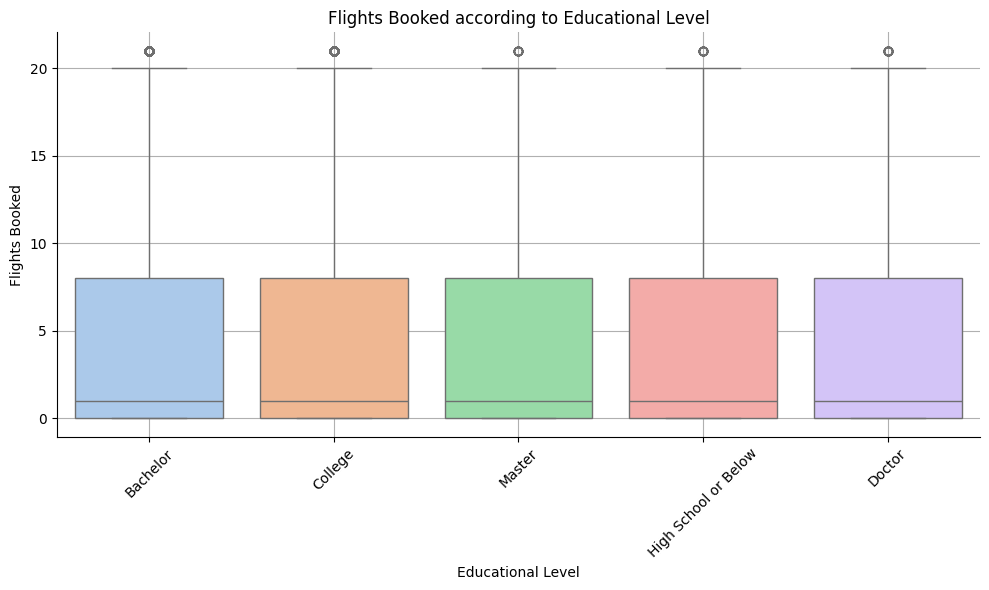

In [8]:
# Establecer el tamaño de la gráfica
plt.figure(figsize=(10, 6))

# Crear el violin plot
sns.boxplot(data=level_education_fly, x="Education", y="Flights_Booked", palette="pastel")

# Ajustar título y etiquetas
plt.title('Flights Booked according to Educational Level')
plt.xlabel('Educational Level')
plt.ylabel('Flights Booked')
plt.xticks(rotation=45)
plt.grid(True)

# quitamos la linea de arriba y de la derecha
plt.gca().spines['right'].set_visible(False) # quitamos la línea de la derecha
plt.gca().spines["top"].set_visible(False) # quitamos la línea de arriba;
# Ajustar el diseño para que las etiquetas no se solapen
plt.tight_layout()
# Mostrar la gráfica
plt.show()


### 3. Prueba Estadística: Realiza una prueba de hipótesis para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.
 
- H0 (Hipótesis Nula): Afirma que no hay efecto, no hay diferencia o no hay relación significativa en la población subyacente. Es la afirmación inicial que se somete a prueba y que se considera verdadera hasta que haya evidencia suficiente para rechazarla.

- H1 (Hipótesis Alternativa): Afirma que existe un efecto, una diferencia o una relación significativa en la población subyacente. Es la afirmación que estás tratando de demostrar con los datos de la muestra.

        Hipótesis: 

    - `HO` --> No existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos. 
    - `H1` --> Existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.

In [15]:
# Función para evaluar la normalidad de los datos
def normalidad(dataframe, columna):
    statistic, p_value = stats.shapiro(dataframe[columna])
    if p_value > 0.05:
        print(f"Con relación a {columna}, los datos SI siguen una distribución normal. (p-value = {p_value:.5f})")
    else:
        print(f"Con relación a {columna}, los datos NO siguen una distribución normal. (p-value = {p_value:.5f})")

# Evaluar la normalidad para cada nivel de educación
for education_level in df['Education'].unique():
    print(f"Evaluando normalidad en el nivel educativo:--> {education_level}")
    nivel_educativo = df[df['Education'] == education_level]
    normalidad(nivel_educativo, 'Flights_Booked')


Evaluando normalidad en el nivel educativo:--> Bachelor
Con relación a Flights_Booked, los datos NO siguen una distribución normal. (p-value = 0.00000)
Evaluando normalidad en el nivel educativo:--> College
Con relación a Flights_Booked, los datos NO siguen una distribución normal. (p-value = 0.00000)
Evaluando normalidad en el nivel educativo:--> Master
Con relación a Flights_Booked, los datos NO siguen una distribución normal. (p-value = 0.00000)
Evaluando normalidad en el nivel educativo:--> High School or Below
Con relación a Flights_Booked, los datos NO siguen una distribución normal. (p-value = 0.00000)
Evaluando normalidad en el nivel educativo:--> Doctor
Con relación a Flights_Booked, los datos NO siguen una distribución normal. (p-value = 0.00000)


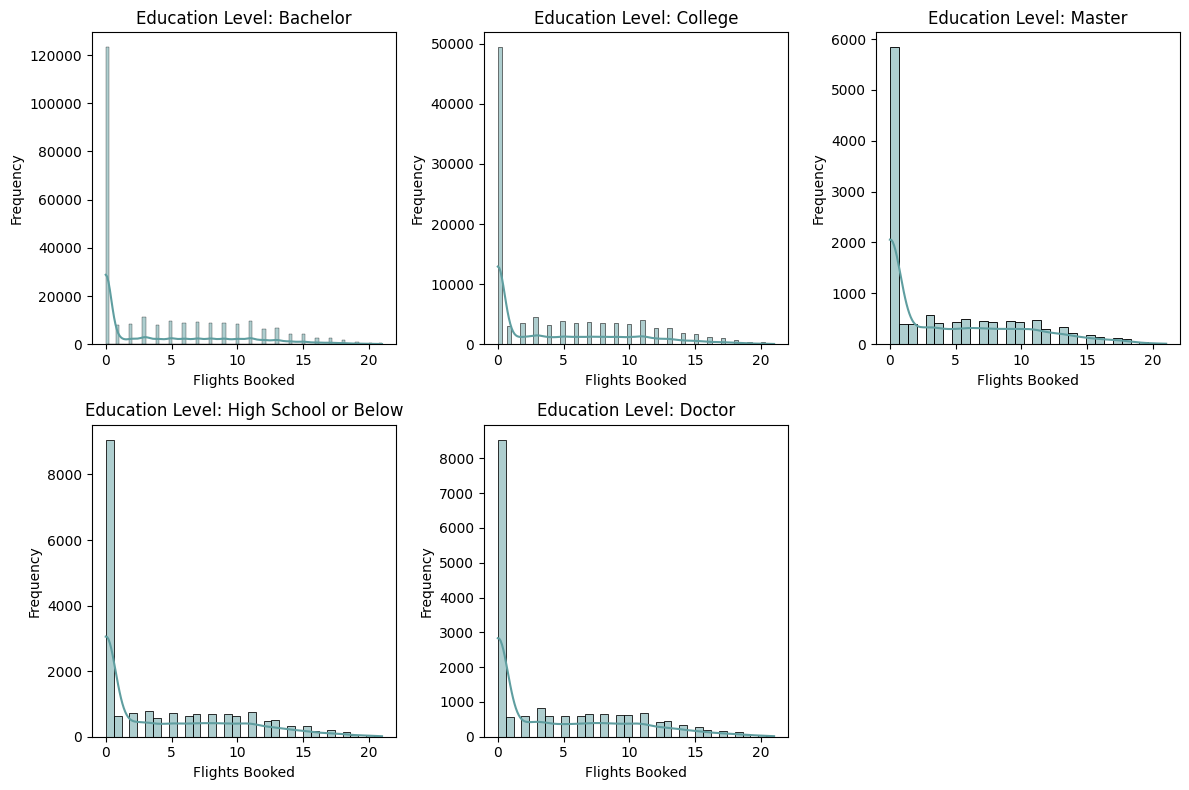

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer el tamaño de la figura
plt.figure(figsize=(12, 8))

# Iterar sobre cada nivel educativo único
for i, education_level in enumerate(df['Education'].unique(), start=1):
    # Filtrar los datos por nivel educativo
    data_subset = df[df['Education'] == education_level]['Flights_Booked']
    
    # Crear un subplot para cada nivel educativo
    plt.subplot(2, 3, i)
    
    # Crear el histograma o gráfico de distribución
    sns.histplot(data=data_subset, kde=True, color='cadetblue')
    
    # Configurar título y etiquetas
    plt.title(f'Education Level: {education_level}')
    plt.xlabel('Flights Booked')
    plt.ylabel('Frequency')

    
    # Ajustar el diseño
    plt.tight_layout()

# Mostrar los gráficos
plt.show()


> 🎯 En base al análisis de normalidad y distribución de datos por cada nivel educativo, se observa que no todos cumplen con los criterios de una distribución normal. Este hallazgo sugiere que las características de los datos varían significativamente entre las diferentes categorías educativas. En consecuencia, se rechaza la hipótesis nula de que los datos siguen una distribución normal estándar. Para una comprensión más detallada de cómo estos datos se agrupan o dispersan visualmente, sería recomendable explorar gráficos que permitan una visualización más intuitiva de estas diferencias

In [15]:
# Definición de la función de homogeneidad
def homogeneidad(dataframe, columna, columna_metrica):
    # Crear tantos conjuntos de datos como categorías tenemos en 'columna'
    valores_evaluar = []
    categorias = dataframe[columna].unique()
    
    for valor in categorias:
        valores_evaluar.append(dataframe[dataframe[columna] == valor][columna_metrica])

    # Realizar la prueba de Levene
    statistic, p_value = stats.levene(*valores_evaluar)
    for valor, datos in zip(categorias, valores_evaluar):
        median_value = datos.median()
        if p_value > 0.05:
            print(f"Las varianzas de {valor} SI SON homogéneas entre grupos. p-value: {p_value:.4f}.")
        else:
            print(f"Las varianzas de {valor} NO son homogéneas entre grupos. p-value: {p_value:.4f}.")

# Evaluar la homogeneidad para 'Education' y 'Flights_Booked'
homogeneidad(df, 'Education', 'Flights_Booked')


Las varianzas de Bachelor NO son homogéneas entre grupos. p-value: 0.0150.
Las varianzas de College NO son homogéneas entre grupos. p-value: 0.0150.
Las varianzas de Master NO son homogéneas entre grupos. p-value: 0.0150.
Las varianzas de High School or Below NO son homogéneas entre grupos. p-value: 0.0150.
Las varianzas de Doctor NO son homogéneas entre grupos. p-value: 0.0150.


In [17]:
# Realizar la prueba de Kruskal-Wallis
groups = [df[df['Education'] == education_level]['Flights_Booked'] for education_level in df['Education'].unique()]
stat, p_value = stats.kruskal(*groups)

print(f'Estadístico de Kruskal-Wallis: {stat:.5f}')
print(f'Valor p: {p_value:.5f}')

if p_value < 0.05:
    print("Existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.")
else:
    print("No existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.")


Estadístico de Kruskal-Wallis: 17.53262
Valor p: 0.00152
Existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.


### 📊 Interpretación de los resultados 📊

**Conclusión** --> Al analizar los datos sobre el número de vuelos reservados según los niveles educativos de los pasajeros, hemos llegado a varias conclusiones significativas: 

* Análisis de Kruskal-Wallis
El estadístico de Kruskal-Wallis calculado es 17.53262, con un valor p de 0.00152. Este resultado indica que existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos. Esto implica que no todos los grupos tienen la misma mediana de vuelos reservados y sugiere que los niveles educativos influyen en la cantidad de vuelos que reservan los pasajeros.

* Prueba de homogeneidad de varianza
Al evaluar la homogeneidad de varianza entre los grupos de niveles educativos, encontramos que las varianzas no son homogéneas entre los grupos. El valor p obtenido fue 0.0150, lo cual está por debajo del umbral comúnmente aceptado de 0.05. Esto significa que las diferencias en las varianzas entre los grupos son estadísticamente significativas.

* Prueba de normalidad
Además, al evaluar la normalidad de los datos de vuelos reservados para cada nivel educativo, encontramos que los datos no siguen una distribución normal. El valor p obtenido fue extremadamente bajo (p-value = 0.00000), lo cual indica que no podemos asumir normalidad en la distribución de vuelos reservados en ningún nivel educativo.

Entonces podemos concluir que:
-  Existe una clara diferencia en el número de vuelos reservados según el nivel educativo de los pasajeros.
-  La evidencia estadística respalda el rechazo de la hipótesis nula de que no hay diferencias entre los grupos.
- La falta de normalidad en los datos y las diferencias significativas en las varianzas entre grupos. 

Aun así, estaría bien considerar otras variables para tener más detalles importantes. 